# Table of Contents

1. [Strategy](#1-strategy)
2. [Code Setup](#2-code-setup)
   1. [Load Crypto Stock Data](#21-load-crypto-stock-data)
   2. [Declare Default Values and Useful Functions](#22-declare-default-values-and-useful-functions)
   3. [Outline All Trades to be Made](#23-outline-all-trades-to-be-made)
   4. [Create the Training Model](#24-create-trading-model)
   5. [Convert the Portfolio History from Crypto Units to USD](#25-convert-portfolio-history-from-crypto-units-to-usd)
3. [Results and Analysis](#3-results-and-analysis)
   1. [Values of Each Asset in the Portfolio Over Time](#36-value-of-each-asset-in-the-portfolio-over-time)
   2. [When the Trades were Made Relative to the Crypto Stock Price History](#37-when-trades-were-made-relative-to-crypto-stock-prices)
   3. [Calculation of Overall Gains](#38-calculate-overall-gains)

# 1. Strategy

- Buy Low, Sell High
- We don't need to diversify, we know all the price histories
- We sometimes sell at the most convenient peak because another opportunity is more lucrative (and we need to sell to buy it)
- We start with BTC because it is oldest crypto (the only one we can buy right from the start)


# 2. Code Setup

This section includes all the code necessary to run the portfolio simulation.


In [197]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter

import pandas as pd
from termcolor import colored

## 2.1 Load Crypto Stock Data

Load the historical price data from the `.csv` files located under `data/crypto/` using pandas, keep only the date and closing price column, and store them in a dictionary for later use.

All historical price data was taken from [Yahoo Finance](https://finance.yahoo.com/).


In [198]:
CRYPTO_PATH = "data/crypto/"
cryptoFiles = [
  "BTC-USD.csv",
  "BNB-USD.csv",
  "DOGE-USD.csv",
  "ETH-USD.csv",
  "SOL-USD.csv",
]

crypto_dataframes = {}

for file in cryptoFiles:
  file_path = CRYPTO_PATH + file
  df = pd.read_csv(file_path)

  # Keep only the Date and Close columns
  df = df[["Date", "Close"]]

  # Store the DataFrame in the dictionary
  crypto_dataframes[file.split("-")[0]] = df

## 2.2 Declare Default Values and Useful Functions

The simulation start on 2015-07-01 and ends on 2024-07-31.

For simplification, we only work in USD. Therefore, the initial balance was converted from CAD to USD on day 1.

There are also 2 helper functions `buy()` and `sell()`. Importantly, `sell()` factors in the capital gains tax of 50% that is applied to every investment's profit.


In [199]:
START_DATE = "2015-07-01"
END_DATE = "2024-07-31"
CRYPTO_COLORS = {
  "BTC": "green",
  "BNB": "red",
  "SOL": "skyblue",
  "ETH": "orange",
  "DOGE": "purple",
  "Cash": "blue",
}

USD_TO_CAD_JULY_2015 = 1.261

# 1000 CAD converted to USD on July 2015
STARTING_BALANCE = 1000 / USD_TO_CAD_JULY_2015

# Create a new DataFrame to log portfolio values
portfolio_df = pd.DataFrame(
  columns=["Date", "Cash", "BTC", "BNB", "SOL", "ETH", "DOGE"]
)
# Set the initial portfolio values
portfolio_df.loc[0] = {
  "Date": START_DATE,
  "Cash": STARTING_BALANCE,
  "BTC": 0,
  "BNB": 0,
  "SOL": 0,
  "ETH": 0,
  "DOGE": 0,
}

cryptoDollarInvestments = {
  "BTC": 0,
  "BNB": 0,
  "SOL": 0,
  "ETH": 0,
  "DOGE": 0,
}


def sell(
  portfolio, commodity, units: int, date, tax: float = 0.5, debug=False
) -> float:
  """
  Returns the amount of cash after selling the units of the commodity at the current price.

  Args:
      units (int): The number of units to sell.
      currentPrice (float): The current price of the commodity.
      tax (float, optional): The capital gains tax rate. Default is 0.5.

  Returns:
      float: The amount of cash after selling the units.
  """
  availableUnits = portfolio.tail(1)[commodity].values[0]

  if units > availableUnits:
    print(
      f"ERROR: Insufficient amount of units to sell. You only have {availableUnits} of {commodity} in your portfolio. You tried to sell {units} units."
    )
    return 0

  commodity_df = crypto_dataframes[commodity]
  currentPrice = commodity_df.loc[commodity_df["Date"] == date, "Close"].values[0]

  gross = units * currentPrice
  gains = gross - cryptoDollarInvestments[commodity]

  cryptoDollarInvestments[
    commodity
  ] = 0  # This simplification only works for trades of max $ amounts

  if gains > 0:
    profit = gross - (gains * tax)
    if debug:
      print(
        f"{date}: {colored("[Capital Gain]", "green")} Selling {units} {commodity} at ${currentPrice:.2f}/{commodity} for a profit of ${profit:.2f} (after tax)\n"
      )
    return profit
  else:
    if debug:
      print(
        f"{date}: {colored("[Capital Loss]", "red")} Selling {units} {commodity} at ${currentPrice:.2f}/{commodity} for a total of ${gains:.2f}\n"
      )
    return gains


def buy(portfolio, commodity, amount: float, date, debug=False) -> float:
  """
  Returns the amount of commodity that can be bought with the buyPrice..
  """
  availableCash = portfolio.tail(1)["Cash"].values[0]
  if amount > availableCash:
    print(
      f"ERROR: Insufficient Cash to buy {amount} of {commodity}. You only have {portfolio['Cash']} in your portfolio."
    )
    return 0

  commodity_df = crypto_dataframes[commodity]
  commodityPrice = commodity_df.loc[commodity_df["Date"] == date, "Close"].values[0]

  cryptoDollarInvestments[
    commodity
  ] += amount  # Keep track of the total amount of dollars invested in the commodity (used for calculating the capital gains tax)

  if debug:
    print(
      f"{date}: Buying ${amount:.2f} ({amount / commodityPrice} {commodity}) worth of {commodity} at ${commodityPrice:.2f}/{commodity}\n"
    )
  return amount / commodityPrice

## 2.3 Outline All Trades to be Made

Each trade was manually made by myself after analysing each crypto's price history.

Since we know the complete price history of each crypto stock, we don't need to speculate about the future price. This means that we can buy an sell the max amount with each trade. There's no need to hedge our bets by diversifying our portfolio.

These choices maximize the % gain of each trade while also not squandering future opportunities with higher possible gains.


In [200]:
TRADES = [
  {"Date": "2015-07-01", "commodity": "BTC", "Type": "buy", "quantity": "max"},
  {"Date": "2017-12-01", "commodity": "BTC", "Type": "sell", "quantity": "max"},
  {"Date": "2017-12-01", "commodity": "BNB", "Type": "buy", "quantity": "max"},
  {"Date": "2021-04-01", "commodity": "BNB", "Type": "sell", "quantity": "max"},
  {"Date": "2021-05-01", "commodity": "SOL", "Type": "buy", "quantity": "max"},
  {"Date": "2021-11-01", "commodity": "SOL", "Type": "sell", "quantity": "max"},
  {"Date": "2022-12-01", "commodity": "SOL", "Type": "buy", "quantity": "max"},
  {"Date": "2024-03-01", "commodity": "SOL", "Type": "sell", "quantity": "max"},
  {"Date": "2024-04-01", "commodity": "ETH", "Type": "buy", "quantity": "max"},
  {"Date": "2024-05-01", "commodity": "ETH", "Type": "sell", "quantity": "max"},
  {"Date": "2024-06-01", "commodity": "SOL", "Type": "buy", "quantity": "max"},
  {"Date": "2024-07-01", "commodity": "SOL", "Type": "sell", "quantity": "max"},
]

# Buy Trade Marker
GREEN_TRIANGLE = mlines.Line2D(
  [],
  [],
  color="green",
  marker="^",
  linestyle="None",
  markersize=7,
  label="Buy Trade",
)
# Sell Trade Marker
RED_TRIANGLE = mlines.Line2D(
  [],
  [],
  color="red",
  marker="v",
  linestyle="None",
  markersize=7,
  label="Sell Trade",
)

## 2.4 Create the Trading Model

The trading model iterates over every month and checks if there's a trade to process. If there is, it is performed.

There can be multiple trades in a day and each will be recorded.

At the end of the simulation, we keep track of the portfolio's final cash value.


In [201]:
def simulate(portfolio, trades, debug=False):
  # Iterate over the dates and log the portfolio values
  for date in crypto_dataframes["BTC"]["Date"]:
    tradeHappened = False
    for trade in trades:
      if trade["Date"] == date:
        if debug:
          print(colored(f"Processing trade: {trade}", "cyan"))
        if trade["Type"] == "buy":
          commodity = trade["commodity"]
          buyQuantity = trade["quantity"]
          if buyQuantity == "max":
            buyQuantity = portfolio.tail(1)["Cash"].values[0]

          units = buy(portfolio, commodity, buyQuantity, date, debug=debug)

          lastRow = portfolio.tail(1)
          newRow = lastRow.copy()

          newRow["Date"] = date
          newRow["Cash"] = lastRow["Cash"] - buyQuantity
          newRow[commodity] = lastRow[commodity] + units
        elif trade["Type"] == "sell":
          commodity = trade["commodity"]
          units = trade["quantity"]
          if units == "max":
            units = portfolio.tail(1)[commodity].values[0]

          sellCash = sell(portfolio, commodity, units, date, debug=debug)

          lastRow = portfolio.tail(1)
          newRow = lastRow.copy()

          newRow["Date"] = date
          newRow["Cash"] = lastRow["Cash"] + sellCash
          newRow[commodity] = lastRow[commodity] - units
        else:
          print("ERROR: Invalid trade type. Use 'buy' or 'sell")
          continue

        portfolio = pd.concat([portfolio, newRow], ignore_index=True)
        tradeHappened = True

    if tradeHappened:
      tradeHappened = False
    else:
      # Duplicate the previous row
      duplicateRow = portfolio.tail(1).copy()
      duplicateRow["Date"] = date
      portfolio = pd.concat([portfolio, duplicateRow], ignore_index=True)

  return portfolio


portfolioHistory = simulate(portfolio_df, TRADES, debug=True)
FINAL_BALANCE = float(portfolioHistory.tail(1)["Cash"].values[0])

Processing trade: {'Date': '2015-07-01', 'commodity': 'BTC', 'Type': 'buy', 'quantity': 'max'}
2015-07-01: Buying $793.02 (2.7859526727343358 BTC) worth of BTC at $284.65/BTC

Processing trade: {'Date': '2017-12-01', 'commodity': 'BTC', 'Type': 'sell', 'quantity': 'max'}
2017-12-01: [Capital Gain] Selling 2.7859526727343358 BTC at $14156.40/BTC for a profit of $20116.04 (after tax)

Processing trade: {'Date': '2017-12-01', 'commodity': 'BNB', 'Type': 'buy', 'quantity': 'max'}
2017-12-01: Buying $20116.04 (2329.4372188771317 BNB) worth of BNB at $8.64/BNB

Processing trade: {'Date': '2021-04-01', 'commodity': 'BNB', 'Type': 'sell', 'quantity': 'max'}
2021-04-01: [Capital Gain] Selling 2329.4372188771317 BNB at $624.08/BNB for a profit of $736936.27 (after tax)

Processing trade: {'Date': '2021-05-01', 'commodity': 'SOL', 'Type': 'buy', 'quantity': 'max'}
2021-05-01: Buying $736936.27 (22456.446411891495 SOL) worth of SOL at $32.82/SOL

Processing trade: {'Date': '2021-11-01', 'commodity

## 2.5 Convert the Portfolio History From Crypto Units to USD

This section converts the crypto amounts in the portfolio history from units (e.g. 1.246 BTC) to USD.

This conversion is helpful when visualizing the data because people have a better frame of reference for USD rather than units of crypto currency.


In [202]:
convertedPortfolioHistory = portfolioHistory.copy()
# Convert the portfolio history from crypto units to USD
for date in portfolioHistory["Date"]:
  for crypto, df in crypto_dataframes.items():
    if date in df["Date"].values:
      cryptoUnits = portfolioHistory.loc[
        portfolioHistory["Date"] == date, crypto
      ].values[0]
      if cryptoUnits > 0:
        cryptoPrice = df.loc[df["Date"] == date, "Close"].values[0]

        convertedPortfolioHistory.loc[
          convertedPortfolioHistory["Date"] == date, crypto
        ] = cryptoUnits * cryptoPrice

# 3. Results and Analysis

## 3.6 Value of each Asset in the Portfolio Over Time

The following charts show the values of each asset in our portfolio over time.

Markers have been added to denote the moment when a trade was made.


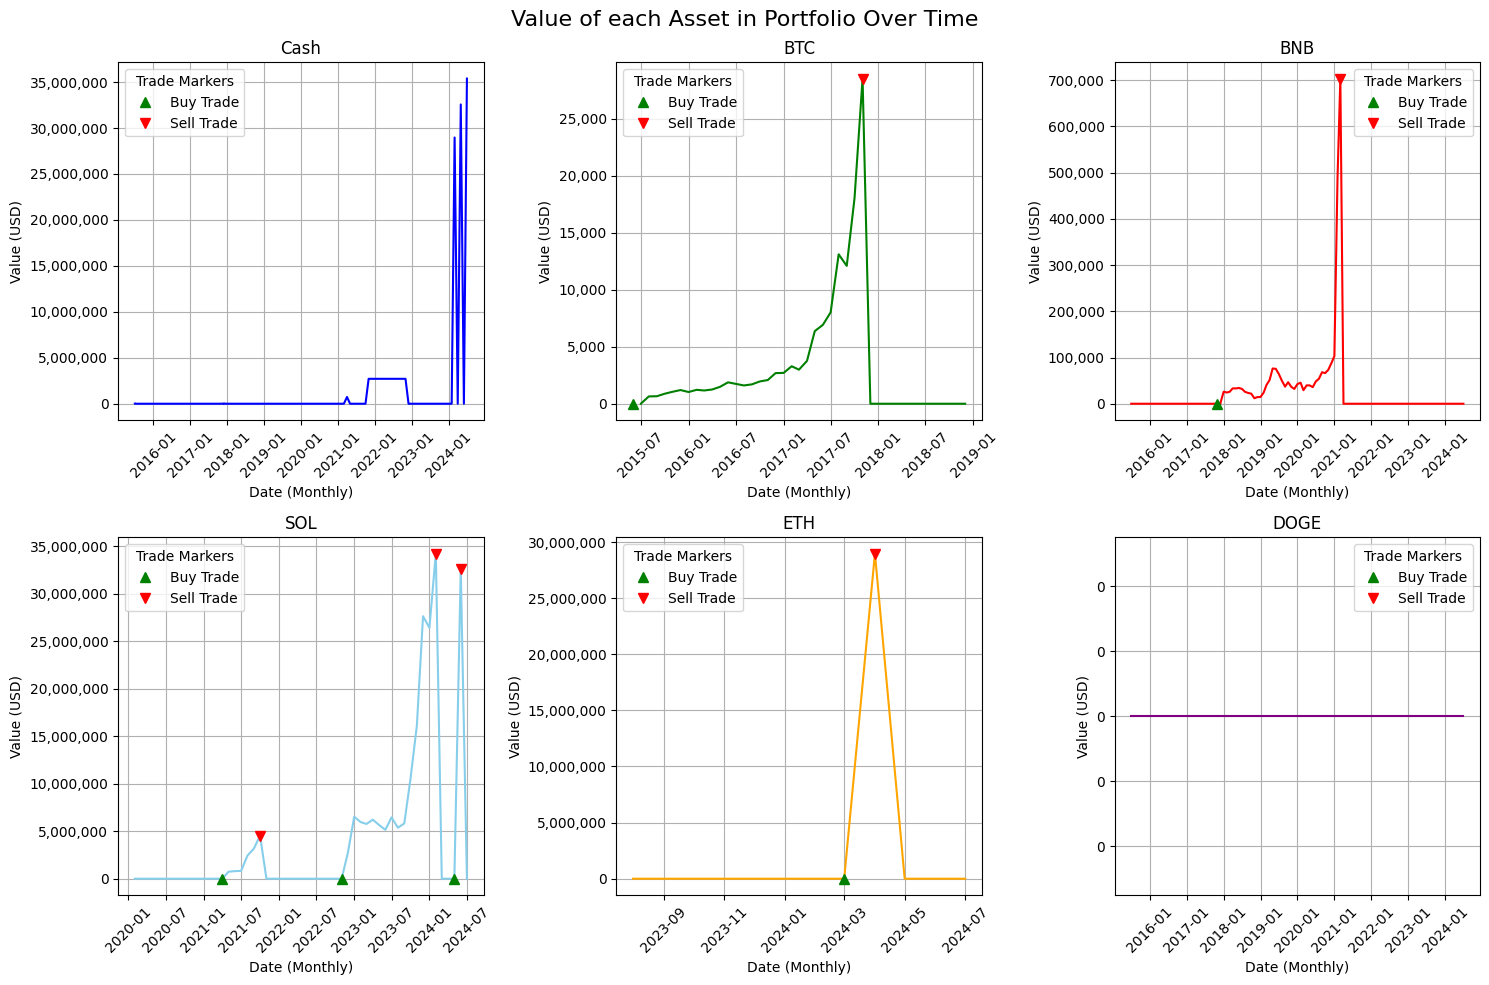

In [203]:
# Get the list of columns excluding the 'Date' column
columns = [col for col in convertedPortfolioHistory.columns if col != "Date"]

convertedPortfolioHistory["Date"] = pd.to_datetime(convertedPortfolioHistory["Date"])

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the 2x3 array of axes for easy iteration
axs = axs.flatten()

# Plot each column in a separate subplot with a different color
for i, column in enumerate(columns):
  # Narrow the data to only include the interesting portions
  match column:
    case "BTC":
      non_zero_data = convertedPortfolioHistory[
        ~(convertedPortfolioHistory["Date"] >= "2019-01-01")
      ]
    case "SOL":
      non_zero_data = convertedPortfolioHistory[
        ~(
          (convertedPortfolioHistory["Date"] >= START_DATE)
          & (convertedPortfolioHistory["Date"] <= "2020-01-01")
        )
      ]
    case "ETH":
      non_zero_data = convertedPortfolioHistory[
        ~(
          (convertedPortfolioHistory["Date"] >= START_DATE)
          & (convertedPortfolioHistory["Date"] <= "2023-07-01")
        )
      ]
    case default:
      non_zero_data = convertedPortfolioHistory

  axs[i].plot(
    non_zero_data["Date"],
    non_zero_data[column],
    color=CRYPTO_COLORS[column],
  )
  axs[i].set_title(column)
  axs[i].set_xlabel("Date (Monthly)")
  axs[i].set_ylabel("Value (USD)")
  axs[i].grid(True)

  # Set x-axis ticks at a certain interval
  axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
  axs[i].tick_params(axis="x", rotation=45)

  # Use ScalarFormatter to avoid scientific notation
  formatter = ScalarFormatter(useOffset=False)
  formatter.set_scientific(False)
  axs[i].yaxis.set_major_formatter(formatter)
  # Add commas to y-axis values
  axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

  # Add markers for trades
  for trade in TRADES:
    tradeType = trade["Type"]
    tradeCommodity = trade["commodity"]
    tradeDate = pd.to_datetime(trade["Date"])

    if column != tradeCommodity:
      continue

    if tradeType == "buy":
      marker = "^"
      color = "green"
    elif tradeType == "sell":
      marker = "v"
      color = "red"

    # Get the previous month for the marker
    previous_month_date = pd.Timestamp(tradeDate) - pd.DateOffset(months=1)
    tradeDate = previous_month_date
    if tradeType == "buy":
      y_value = 0
    elif tradeType == "sell":
      # Retrieve the y value for the previous month
      y_value = convertedPortfolioHistory.loc[
        convertedPortfolioHistory["Date"] == previous_month_date, column
      ].values[0]

    # Plot the marker
    axs[i].plot(tradeDate, y_value, marker=marker, color=color, markersize=7)

  # Add the marker legend
  axs[i].legend(handles=[GREEN_TRIANGLE, RED_TRIANGLE], title="Trade Markers")

# Add a title to the figure
fig.suptitle("Value of each Asset in Portfolio Over Time", fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 3.7 When Trades were Made Relative to Crypto Stock Prices

This set of plots illustrates what the crypto stock prices were when the trades were made. They help show the strategy of buying low and selling high.

It can also help you visualize when the trade were made.


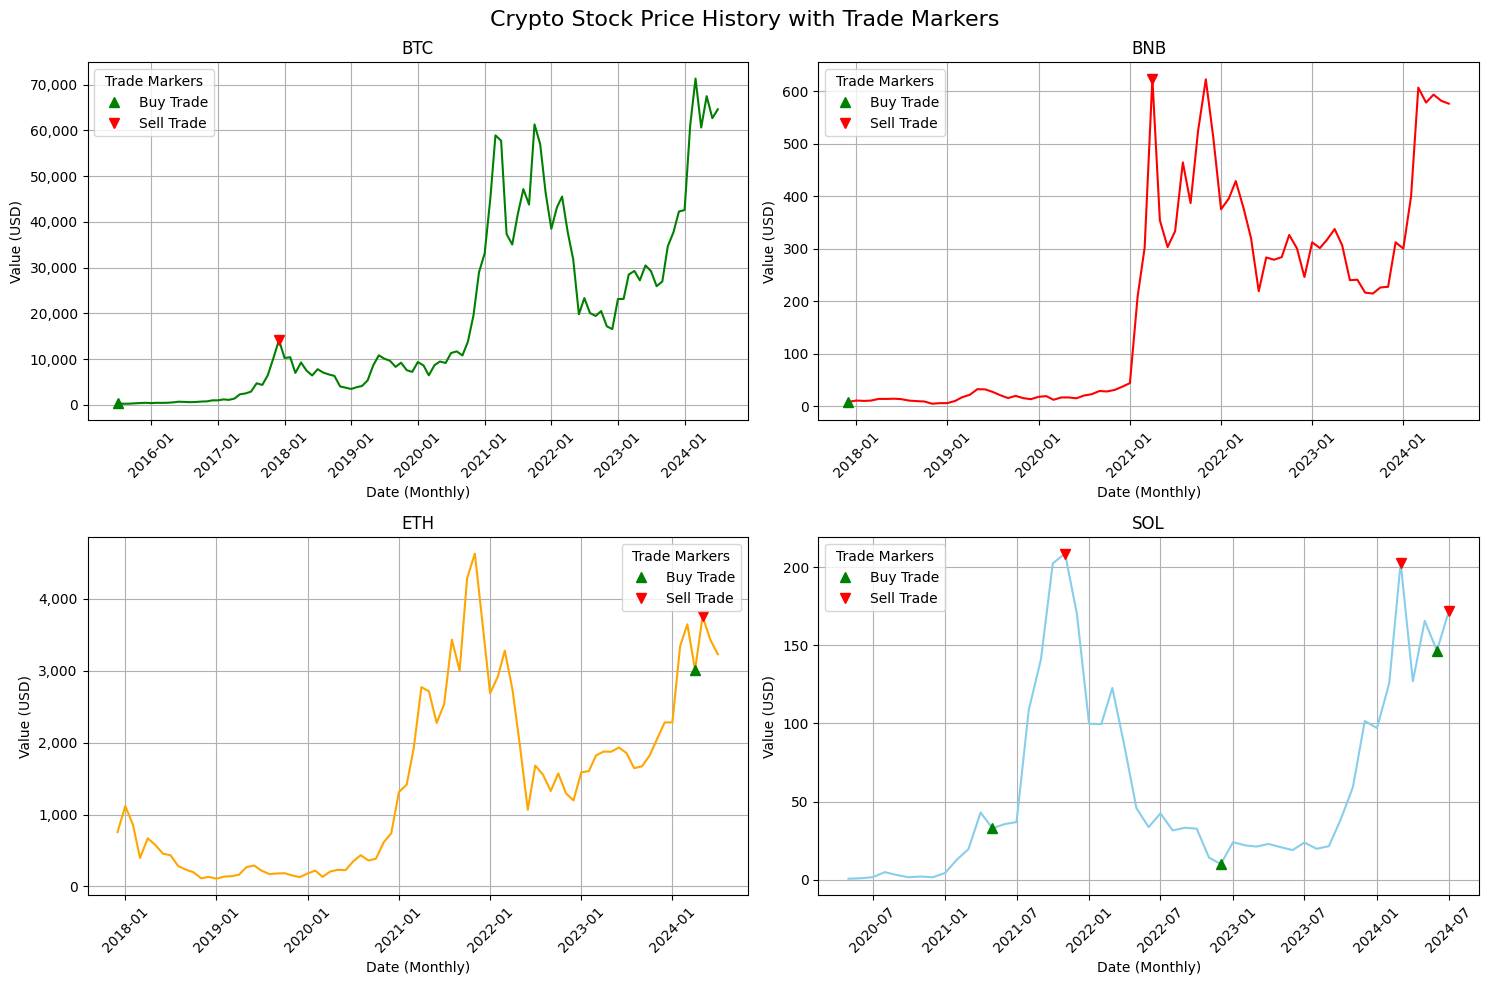

In [204]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Flatten the 2x2 array of axes for easy iteration
axs = axs.flatten()

crypto_dataframes_copy = crypto_dataframes.copy()
# Remove the DOGE df since we made no trades with it
if "DOGE" in crypto_dataframes_copy:
  crypto_dataframes_copy.pop("DOGE")

# Plot each column in a separate subplot with a different color
for i, (crypto, df) in enumerate(crypto_dataframes_copy.items()):
  df = df.copy()
  df["Date"] = pd.to_datetime(df["Date"])

  axs[i].plot(
    df["Date"],
    df["Close"],
    color=CRYPTO_COLORS[crypto],
  )
  axs[i].set_title(f"{crypto}")
  axs[i].set_xlabel("Date (Monthly)")
  axs[i].set_ylabel("Value (USD)")
  axs[i].grid(True)

  # Set x-axis ticks at a certain interval
  axs[i].xaxis.set_major_locator(mdates.AutoDateLocator())
  axs[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
  axs[i].tick_params(axis="x", rotation=45)

  # Use ScalarFormatter to avoid scientific notation
  formatter = ScalarFormatter(useOffset=False)
  formatter.set_scientific(False)
  axs[i].yaxis.set_major_formatter(formatter)
  # Add commas to y-axis values
  axs[i].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x):,}"))

  # Add markers for trades
  for trade in TRADES:
    tradeType = trade["Type"]
    tradeCommodity = trade["commodity"]
    tradeDate = pd.to_datetime(trade["Date"])

    if crypto != tradeCommodity:
      continue

    if tradeType == "buy":
      marker = "^"
      color = "green"
    elif tradeType == "sell":
      marker = "v"
      color = "red"

    # Get y value for the marker
    y_value = df.loc[df["Date"] == tradeDate, "Close"].values[0]
    # Plot the marker
    axs[i].plot(tradeDate, y_value, marker=marker, color=color, markersize=7)

  # Add the marker legend
  axs[i].legend(handles=[GREEN_TRIANGLE, RED_TRIANGLE], title="Trade Markers")

fig.suptitle(
  "Crypto Stock Price History with Trade Markers",
  fontsize=16,
)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 3.8 Calculation of Overall Gains

b. Calculate your overall gains over the investment period.

- All final amounts are to be calculated to their value at the end of July 2024.


In [205]:
print(f"Starting Balance: ${STARTING_BALANCE:,.2f}")
print(f"Final Balance: ${FINAL_BALANCE:,.2f}\n")

# Account for Inflation
STARTING_VALUE = 1000
final_value_pre_inflation = 10_000

TOTAL_CPI_2015_07 = 127.3  # Consumer Price Index for July 2015
TOTAL_CPI_2024_06 = (
  161.4  # Consumer Price Index for June 2024 (Didn't have July 2024 data)
)

INFLATION_FACTOR = TOTAL_CPI_2015_07 / TOTAL_CPI_2024_06

finalBalancePostInflation = FINAL_BALANCE * INFLATION_FACTOR

print(
  f"Final balance post-inflation (Relative to July 2015): ${finalBalancePostInflation:,.2f}"
)

# Calculate the percent gain (relative to July 2015)
percent_gain = ((finalBalancePostInflation - STARTING_BALANCE) / STARTING_BALANCE) * 100
print(f"Percent gain (Relative to July 2015): {percent_gain:,.2f}%")

Starting Balance: $793.02
Final Balance: $35,378,663.46

Final balance post-inflation (Relative to July 2015): $27,903,989.21
Percent gain (Relative to July 2015): 3,518,593.04%


## Comparison with Other Strategy

Below is a simulation of what would happen if you performed the simplest strategy with all of the crypto currencies.

**Strategy:** Buy the maximum amount as soon as you can, hold, and sell at the crypto's peak price.


In [206]:
# Ignore this color hack =)

COLOR_MAPPING = {"purple": "magenta", "orange": "yellow", "skyblue": "cyan"}


# Function to get a supported color for colored
def get_supported_color(color):
  return COLOR_MAPPING.get(color, color)

In [207]:
# Initialize a dictionary to store the results
max_values = {}

# Initialize a dictionary to store the hold trades
HOLD_TRADES = {}

# Initialize a dictionary to store the hold portfolios
HOLD_PORTFOLIOS = {}

# Iterate over each crypto file
for crypto, df in crypto_dataframes.items():
  df = df.copy()

  # Find the row with the maximum 'High' value
  max_row = df.loc[df["Close"].idxmax()]

  # Store the date and the maximum value
  max_values[crypto] = {"Date": max_row["Date"], "Max Value": max_row["Close"]}

  # Define hold trades for each crypto
  HOLD_TRADES[crypto] = [
    {
      "Date": df.head(1)["Date"].values[0],
      "commodity": crypto,
      "Type": "buy",
      "quantity": "max",
    },
    {"Date": max_row["Date"], "commodity": crypto, "Type": "sell", "quantity": "max"},
  ]

  # Create a new DataFrame to log portfolio values
  HOLD_PORTFOLIOS[crypto] = pd.DataFrame(
    columns=["Date", "Cash", "BTC", "BNB", "SOL", "ETH", "DOGE"]
  )
  # Set the initial portfolio values
  HOLD_PORTFOLIOS[crypto].loc[0] = {
    "Date": START_DATE,
    "Cash": STARTING_BALANCE,
    "BTC": 0,
    "BNB": 0,
    "SOL": 0,
    "ETH": 0,
    "DOGE": 0,
  }

holdPortfolioHistories = {}

for crypto, trades, portfolio in zip(
  HOLD_PORTFOLIOS.keys(), HOLD_TRADES.values(), HOLD_PORTFOLIOS.values()
):
  portfolioHistory = simulate(portfolio, trades)
  holdPortfolioHistories[crypto] = portfolioHistory

  FINAL_BALANCE = float(portfolioHistory.tail(1)["Cash"].values[0])
  print(
    colored(
      f"Holding {crypto}:",
      get_supported_color(CRYPTO_COLORS[crypto])
      if CRYPTO_COLORS[crypto] in ["purple", "orange", "skyblue"]
      else CRYPTO_COLORS[crypto],
    )
  )
  print(f"Starting Balance: ${STARTING_BALANCE:,.2f}")
  print(f"Final Balance (Pre Inflation): ${FINAL_BALANCE:,.2f}\n")

Holding BTC:
Starting Balance: $793.02
Final Balance (Pre Inflation): $99,762.59

Holding BNB:
Starting Balance: $793.02
Final Balance (Pre Inflation): $29,051.75

Holding DOGE:
Starting Balance: $793.02
Final Balance (Pre Inflation): $15,314.76

Holding ETH:
Starting Balance: $793.02
Final Balance (Pre Inflation): $2,823.30

Holding SOL:
Starting Balance: $793.02
Final Balance (Pre Inflation): $145,549.30



As you can see, none of the final amounts come close to our "Buy Low Sell High" strategy.
